## Cargar librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from unicodedata import normalize
from wordcloud import WordCloud
import tensorflow as tf
import html
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import seaborn as sns
import matplotlib.pyplot as ptl

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import Consultas_entrenar as ent

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Cargar datos y pre-procesar los datos

In [4]:
dataset= pd.read_excel('feedback_todo.xls')


In [5]:
print(len(dataset))
dataset.head()

12153


,KEY1,FEDORI,ATENCION,CLARIDAD,ESFUERZO,RECOMENDACION,TIEMPO,UTILIDAD,RESOLVIO,KEY2,DESCRIPTION
0,10007,PRESENCIAL,10.0,NaN,NaN,10.0,NaN,NaN,"Aún no se resolvió, ¿Por qué?",10007,Servicio dentro de las expectativas Servicio...
1,10012,PRESENCIAL,10.0,NaN,NaN,9.0,NaN,NaN,"Si, en el primer contacto",10012,
2,10016,PRESENCIAL,10.0,NaN,NaN,10.0,NaN,NaN,"Sí, después de varios contactos",10016,
3,10021,PRESENCIAL,10.0,NaN,NaN,10.0,NaN,NaN,"Si, en el primer contacto",10021,
4,10026,PRESENCIAL,10.0,NaN,NaN,10.0,NaN,NaN,"Si, en el primer contacto",10026,


In [6]:
dataset.dtypes

KEY1               int64
FEDORI            object
ATENCION         float64
CLARIDAD         float64
ESFUERZO          object
RECOMENDACION    float64
TIEMPO            object
UTILIDAD         float64
RESOLVIO          object
KEY2               int64
DESCRIPTION       object
dtype: object

In [7]:
print(dataset['ATENCION'].unique())
print(dataset['CLARIDAD'].unique())
print(dataset['ESFUERZO'].unique())
print(dataset['RECOMENDACION'].unique())
print(dataset['TIEMPO'].unique())
print(dataset['UTILIDAD'].unique())
print(dataset['RESOLVIO'].unique())

[10.  9.  8. nan  1.  4.  7.  5.  2.  6.  3.]
[nan 10.  8.  3.  9.  7.  6.  5.  4.  1.  2.]
[nan 'Mucho' 'Muy poco' 'Nada' 'Poco']
[10.  9. nan  8.  7.  5.  4.  2.  1.  6.  3.]
[nan '10' '9' '3' '8' '5' '7' '4' '6' '1' '2' 'si' 'no' 'SI']
[nan  5. 10.  3.  8.  6.  9.  7.  1.  4.  2.]
['Aún no se resolvió, ¿Por qué?' 'Si, en el primer contacto'
 'Sí, después de varios contactos' nan 'SI' 'NO']


In [8]:

dataset['ESFUERZO'] = dataset['ESFUERZO'].replace('Mucho' ,'1')
dataset['ESFUERZO'] = dataset['ESFUERZO'].replace('Poco' ,'3')
dataset['ESFUERZO'] = dataset['ESFUERZO'].replace('Muy poco' ,'6')
dataset['ESFUERZO'] = dataset['ESFUERZO'].replace('Nada' ,'10')

dataset['RESOLVIO'] = dataset['RESOLVIO'].replace('Aún no se resolvió, ¿Por qué?' ,'1')
dataset['RESOLVIO'] = dataset['RESOLVIO'].replace('Sí, después de varios contactos' ,'5')
dataset['RESOLVIO'] = dataset['RESOLVIO'].replace('Si, en el primer contacto' ,'10')
dataset['RESOLVIO'] = dataset['RESOLVIO'].replace('SI' ,'10')
dataset['RESOLVIO'] = dataset['RESOLVIO'].replace('NO' ,'1')

dataset['TIEMPO'] = dataset['TIEMPO'].replace('no' ,'1')
dataset['TIEMPO'] = dataset['TIEMPO'].replace('NO' ,'1')
dataset['TIEMPO'] = dataset['TIEMPO'].replace('si' ,'10')
dataset['TIEMPO'] = dataset['TIEMPO'].replace('SI' ,'10')

dataset['TIEMPO']=dataset['TIEMPO'].astype(float).round(2)
dataset['RESOLVIO']=dataset['RESOLVIO'].astype(float).round(2)
dataset['ESFUERZO']=dataset['ESFUERZO'].astype(float).round(2)

In [9]:
dataset.dtypes

KEY1               int64
FEDORI            object
ATENCION         float64
CLARIDAD         float64
ESFUERZO         float64
RECOMENDACION    float64
TIEMPO           float64
UTILIDAD         float64
RESOLVIO         float64
KEY2               int64
DESCRIPTION       object
dtype: object

In [10]:
suma=dataset.iloc[:,2:9].sum(axis=1)
cuenta=dataset.iloc[:,2:9].count(axis=1)
dataset["promedio"]=suma/cuenta
dataset["sentimiento"]="positivo"
dataset.loc[dataset["promedio"]<7, "sentimiento"]="negativo"


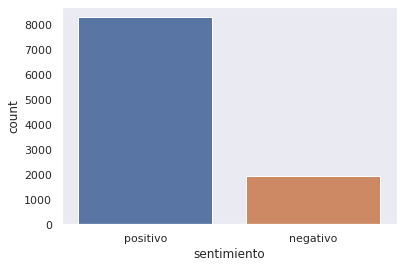

In [135]:
sns.countplot(data=dataset,x='sentimiento')

In [12]:
dataset= dataset[["FEDORI","DESCRIPTION", "promedio", "sentimiento"]]
dataset= dataset.loc[dataset["DESCRIPTION"]!="             ",]
dataset= dataset.loc[dataset["DESCRIPTION"]!=" ",]
dataset= dataset.loc[dataset["DESCRIPTION"]!="",]

In [13]:
dataset.dropna( inplace=True)

## Palabras mas usadas

In [ ]:
!pip3 install -U spacy
!python -m spacy download es
!python3 -m spacy download es_core_news_md


In [ ]:
import spacy
nlp = spacy.load('es_core_news_md')
from nltk import SnowballStemmer
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('gutenberg')


In [15]:
def top_palabras_logo(corpus):
    plt.figure(figsize = (12,12)) 
    mask = np.array(Image.open("logo_Caja.png"))
    wc = WordCloud(min_font_size = 3,  max_words = 300, background_color="white", mask=mask).generate(" ".join(corpus))
    plt.imshow(wc,interpolation = 'bilinear')
    plt.axis("off")
    #plt.savefig("img/palabras.png", format="png")


In [16]:
def top_palabras(corpus):
    plt.figure(figsize = (20,20)) 
    wc = WordCloud(min_font_size = 4,  max_words = 300 , width = 1600 , height = 800).generate(" ".join(corpus))
    plt.imshow(wc,interpolation = 'bilinear')

In [17]:
def corpus_x_tipo(dataset, lista):
  for item in lista:
    data=dataset[dataset["FEDORI"]==item]
    corpus=ent.spacy_lematizar(data["DESCRIPTION"], ["ADJ"] )
  return corpus

In [18]:
def freq_words(texto):
  allWords = nltk.tokenize.word_tokenize(texto)
  allWordDist = nltk.FreqDist(w.lower() for w in allWords)
  tabla_freq=pd.DataFrame(allWordDist.most_common(10), columns=['palabra', 'freq'])
  return tabla_freq

In [21]:
sns.set(style="dark")

In [112]:
resultado=pd.DataFrame(columns=['palabra', 'freq', 'origen'])
origen=dataset.FEDORI.unique()
for item in origen:
  cor_consulta=corpus_x_tipo(dataset, [item])
  freq_consulta=freq_words(' '.join(cor_consulta))
  freq_consulta['origen']= item
  resultado=pd.concat([resultado, freq_consulta])

In [ ]:
cor_consulta=corpus_x_tipo(dataset, ['PENSION'])
freq_consulta=freq_words(' '.join(cor_consulta))
graf_palabra_freq(freq_consulta)

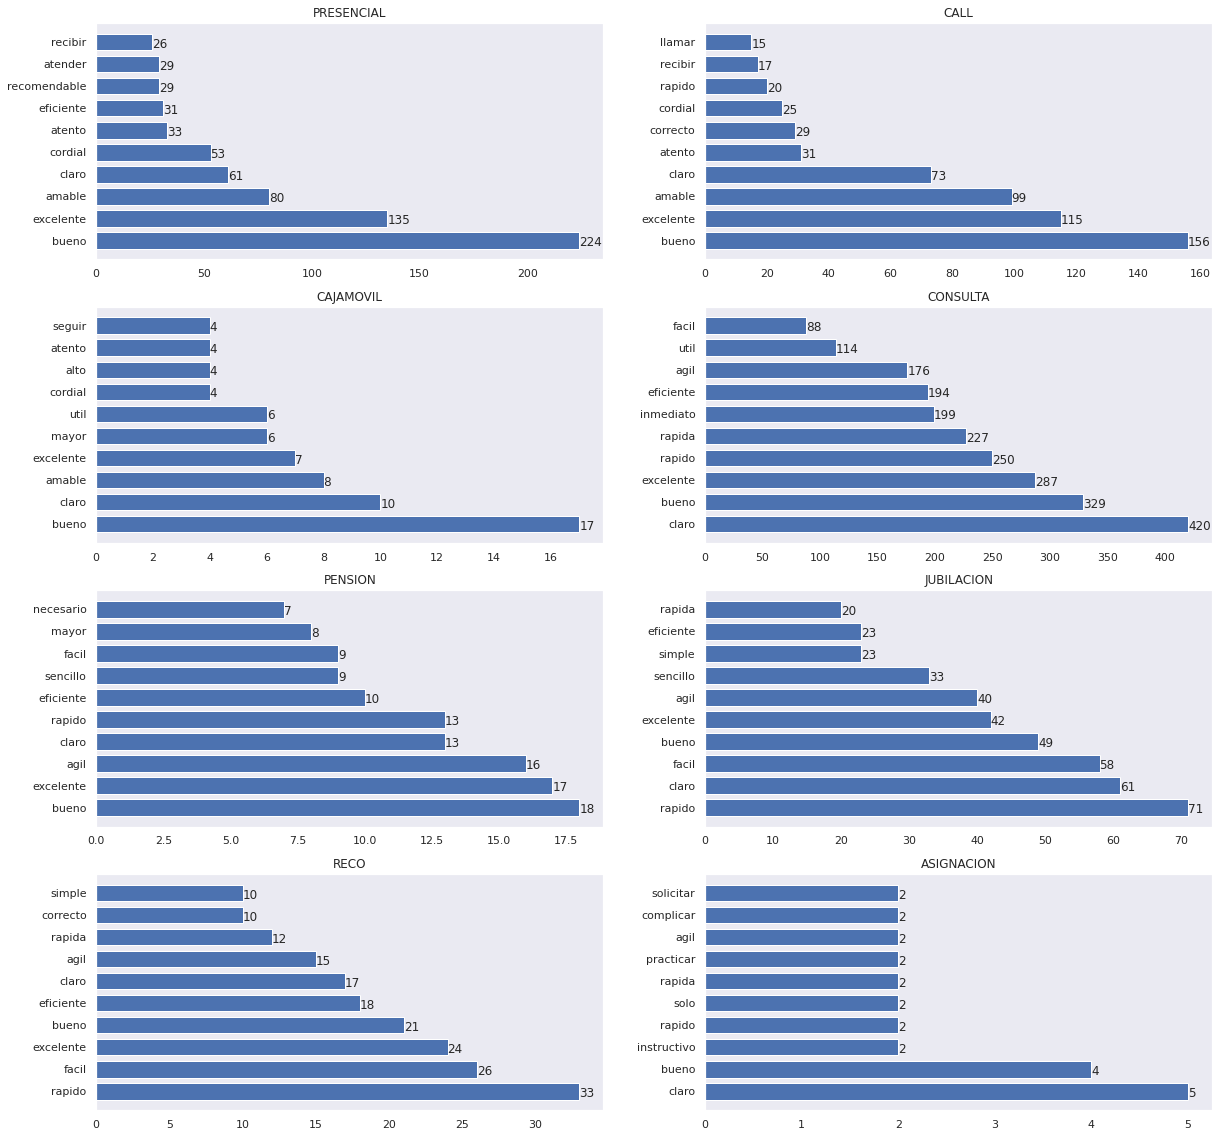

In [134]:
filas=int(len(origen)/2)
cant=0
fig, axs = plt.subplots(filas, 2, figsize=(20, 20))
for i in range(0, len(axs)):
  for j in range(0,2):
    x=resultado.loc[resultado['origen']==origen[cant], 'palabra'].tolist()
    y=resultado.loc[resultado['origen']==origen[cant], 'freq'].tolist()
    axs[i][j].set_title(origen[cant])
    width = 0.75 
    axs[i][j].barh(x, y, width)
    for item, v in enumerate(y):
      axs[i][j].text(v, item -0.25 , str(v))
    cant=cant+1


#fig.subtitle('Categorical Plotting');

In [136]:
corpus= ent.spacy_lematizar(dataset["DESCRIPTION"], ["ADJ"] )

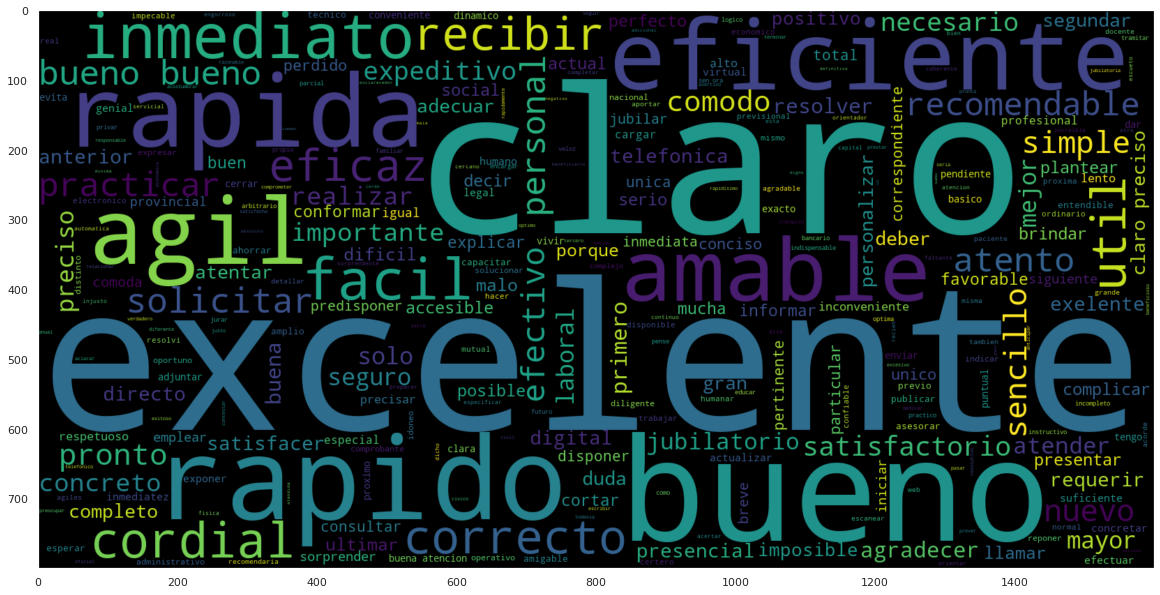

In [137]:
top_palabras(corpus)

In [ ]:
top_palabras_logo(corpus)

## Analisis de sentimiento

In [138]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset["DESCRIPTION"], dataset["sentimiento"], test_size=0.2, random_state=0)

print("Numero de filas X_train dataset: ", X_train.shape)
print("Numero de filas y_train dataset: ", y_train.shape)
print("Numero de filas X_test dataset: ", X_test.shape)
print("Numero de filas y_test dataset: ", y_test.shape)

Numero de filas X_train dataset:  (8165,)
Numero de filas y_train dataset:  (8165,)
Numero de filas X_test dataset:  (2042,)
Numero de filas y_test dataset:  (2042,)


In [139]:
corpus=ent.armar_bag_of_words(X_train)

In [140]:
y_train=pd.DataFrame(y_train)
y_train['corpus']=corpus
y_train= y_train.loc[y_train["corpus"]!='',] # eliminar encuentas sin comentarios

In [149]:
positivo= y_train[y_train["sentimiento"]=='positivo']
negativo= y_train[y_train["sentimiento"]=='negativo']

In [154]:
import imblearn
from sklearn.utils import resample
positivo = resample(positivo, replace=False, n_samples=len(negativo), random_state=123) 

In [157]:
train=pd.concat([negativo, positivo])

In [160]:
X_train_count=ent.contar_palabras(train["corpus"], 3000)

In [161]:
y_train= pd.get_dummies(train, columns=['sentimiento'])

### Red neuronal

In [163]:
ann=tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=20, activation="relu"))
ann.add(tf.keras.layers.Dense(units=2, activation='softmax'))
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [165]:
ann.fit(X_train_count, y_train.iloc[:, 1:], epochs=10, batch_size=32)
ann.save('modelSentimentAnalysis.h5')

Epoch 1/10
71/71 [==============================] - 0s 2ms/step - loss: 0.6179 - accuracy: 0.7079
Epoch 2/10
71/71 [==============================] - 0s 2ms/step - loss: 0.4587 - accuracy: 0.8224
Epoch 3/10
71/71 [==============================] - 0s 2ms/step - loss: 0.3660 - accuracy: 0.8606
Epoch 4/10
71/71 [==============================] - 0s 2ms/step - loss: 0.3055 - accuracy: 0.8905
Epoch 5/10
71/71 [==============================] - 0s 2ms/step - loss: 0.2606 - accuracy: 0.9110
Epoch 6/10
71/71 [==============================] - 0s 2ms/step - loss: 0.2274 - accuracy: 0.9252
Epoch 7/10
71/71 [==============================] - 0s 2ms/step - loss: 0.2023 - accuracy: 0.9288
Epoch 8/10
71/71 [==============================] - 0s 2ms/step - loss: 0.1806 - accuracy: 0.9354
Epoch 9/10
71/71 [==============================] - 0s 2ms/step - loss: 0.1632 - accuracy: 0.9448
Epoch 10/10
71/71 [==============================] - 0s 2ms/step - loss: 0.1496 - accuracy: 0.9519


### Evaluar

In [178]:
corpus_test=ent.armar_bag_of_words(X_test)
y_test["corpus"]=corpus_test
#test=pd.concat([pd.DataFrame(corpus_test), pd.DataFrame(y_test)])


In [182]:
len(y_test)

1300

In [181]:
y_test= y_test.loc[y_test["corpus"]!='',]

In [183]:
cv_loaded = pickle.load(open("countVectorizer", "rb"))
obse_vec=cv_loaded.transform(y_test["corpus"]).toarray()

y_pred_test=ann.predict(obse_vec)

In [188]:
y_test.iloc[:,0:2].values.argmax(axis=1)

array([0, 1, 1, ..., 0, 1, 1])

In [191]:
cm = confusion_matrix(y_test.iloc[:,0:2].values.argmax(axis=1), y_pred_test.argmax(axis=1))
print(cm)
accuracy_score(y_test.iloc[:,0:2].values.argmax(axis=1), y_pred_test.argmax(axis=1))

[[181  69]
 [232 818]]


0.7684615384615384

In [172]:
resultado=pd.concat([pd.DataFrame(corpus_test),  pd.DataFrame(y_pred_test)], axis=1)
resultado.to_excel("resultado.xls")